<a href="https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/classification_option1_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Stage1 "class" Classification

![Proposed Architecture](https://raw.githubusercontent.com/pswaruppk/GL_CAPSTONE/master/data/classification_stage1.PNG)

#### Stage2 "Target" classification
![Proposed Architecture](https://raw.githubusercontent.com/pswaruppk/GL_CAPSTONE/master/data/classification_stage2.PNG)

#Hybrid Model

**With this notebook we are trying to build classification Module of option 1 architecture which involves Pre-processing and Classification models of InceptionV3(stage 1) and Feed Forward Neural Network(FFNN)(stage 2) that are executed sequentially.**

**Classification Stage 1:** Classification of classes(No Lung Opacity/Not Normal, Normal and Lung Opacity) using InceptioinV3. The output of this will form part of input for stage 2 classification.

**Classification Stage 2:** Classification of Target(Pneumonia/Not Pneumonia) using Feed Forward Nueral Network based on stage 1 output and few metadata features(Age, Sex & View Position) as input.

**Classification:**
  1. ChexNet- Densnet121
  2. VGG16
  3. **InceptionV3**-This model is implemented in this notebook.
  4. InceptionRestNetV2
  5. **Feed Forward Neural Network**-This model is implemented in this notebook

Detection:
  RetinaNet based architecture
  1. ResNet101 
  2. ResNet152

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
os.getcwd()

'/content/drive/My Drive/rsna-pneumonia-detection-challenge'

## Model Parameters

In [ ]:
#Set global parameters here
BASE_MODEL = "InceptionV3"
MODEL_NAME  = "Option-1" + "." + BASE_MODEL
if os.path.isdir(MODEL_NAME) == False:
  os.mkdir(MODEL_NAME)
WEIGHTS_FILE = MODEL_NAME+"/" + "weights.best.final1.h5"
HISTORY_FILE = MODEL_NAME+"/" +"history_final1.csv"
PREDICTION_FILE = MODEL_NAME+"/" + "prediction_final1.pkl"
BATCH_SIZE = 32
IMAGE_SIZE = 299 #target image width
IMG_WIDTH = 1024 #Original image width
FORCE_TRAINING = False #True , change it to force training
DROPOUT = 0.25 # [0, 0.25, 0.5]
DENSE_COUNT = 128 # [32, 64, 128, 256]
LEARN_RATE = 1e-3 # [1e-4, 1e-3, 4e-3]
ALPHA = 1.0
EPOCHS = 12

- Each notebook is structured and designed in such a way by just sepcifying the name of the base model a new model could be configured.
- This is made possible by creating a separate notebook containing necessary utility funcitions which can be called in this notebook.
- The following parameters are set at this stage and can be tuned without touching the rest of the flow. 
 - Here we have option to load the model weights and start afresh or controlling force training from previous pretrained model weights so to keep the continuum of the training process. 
 - Different model has different image input requirement which can be globally set from here.
 - Setting hyper-parameters like: Dropout value, Dense layer count, Learning Rate, Epochs and Batch size.




In [ ]:
oldPath = os.getcwd()
utility_path = "/content/drive/My Drive/GL_CAPSTONE"
os.chdir(utility_path)
%run pneumonia_utility.ipynb
baseModel,preprocess_input = selectBaseModel(BASE_MODEL)
os.chdir(oldPath)
print(os.getcwd())
print(baseModel,preprocess_input)

Loading functions from Pneumonia utility notebook
Loading pydicom package
Setting baseModel : InceptionV3
<module 'tensorflow.keras.applications.inception_v3' from '/usr/local/lib/python3.6/dist-packages/tensorflow/keras/applications/inception_v3/__init__.py'>
global BaseModel; BaseModel =np.InceptionV3
global preprocess_input; preprocess_input =np.preprocess_input
<class 'function'>
/content/drive/My Drive/rsna-pneumonia-detection-challenge
<function InceptionV3 at 0x7feda8c45730> <function preprocess_input at 0x7feda8c45840>


- Loading all utility functions and specified model and its preprocessing input package. We would reemphasise that the loading of preprocessing input package is restricted only to the relevant model chosen in the model mapping. 
- The notebook created for Phase 1 was already too long and heavy. So continuing the rest of the work in same notebook was not feasible as we were experimenting with different architectures. 
- This challenge of creating different notebooks for different activity and linking them together was overcome by finding solution by referring internet. 
- We have used different notebooks for different models, phase 1 submission and for utility functions. 
We are now able to interlink and execute other jupyter notebooks from current notebook and thereby use multiple notebooks and share functions created across multiple applications. 

In [ ]:
baseModel,preprocess_input

(<function tensorflow.python.keras.applications.inception_v3.InceptionV3>,
 <function tensorflow.python.keras.applications.inception_v3.preprocess_input>)

In [ ]:
image_shape = MODEL_MAP[BASE_MODEL]['input_shape']
IMAGE_SIZE = image_shape[0]
image_shape,IMAGE_SIZE

((299, 299, 3), 299)

- Generically setting the model input image size as required for the model selected. 

In [ ]:
#Loading full data
full_df,bbox_map,class_enc = loadData()

Loading full CXR info
Loading bbox map


- The loadData utility draws from different csv files created during milestone 1 for EDA, metadata analysis and VGG16 implementations and creates a comprehensive dataframe.
- The dataframe so created contains bounding box details, metadata, encoded class and path of image file for use down the line.

In [ ]:
full_df.head(2)

,Unnamed: 0,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,51,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/0004cfab-14fd-4e49-80ba-6...
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,48,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...


In [ ]:
full_df.drop(full_df.columns[0],inplace=True,axis=1)

In [ ]:
print('{}:Total Pneumonia Patient'.format(len(full_df[full_df.Target == 1])))

9555:Total Pneumonia Patient


In [ ]:
#Split the dataset  into 3 train/valid/test
unbalanced_train_df, valid_df, test_df = splitData(full_df,target='class')

(21347, 14) training data
(5337, 14) raw validation data
(2668, 14) Validation data
(2669, 14) test data


- The full dataset is split into training, validation and test dataset in the ratio of 80:10:10
- As we have set stratify based on target, the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.  This is evident from the following pie charts.
- This will ensure that the consistency in the split dataset is retained and imbalance continues as in original data.
- However, as a next step we have balanced only the training dataset so that there is no bias while training the model. The balancing is done based on class variable using random sampling. 
- Due to constrain in computational resources and time required for training, the sample size is reduced to the least class count(which is pneumonia class) of 4208 and hence the training set will consists of 4208 number of records in each class with total training size of 12624. 

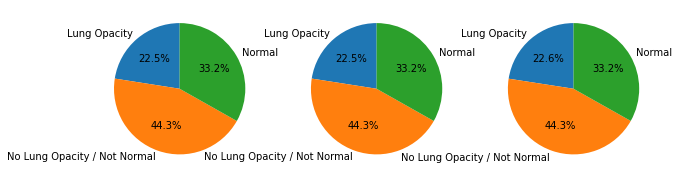

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 3, figsize=(10,7))
unique_values, count = np.unique(unbalanced_train_df['class'], return_counts=True)
ax[0].pie(count, labels = ['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
          autopct='%1.1f%%', startangle=90)

unique_values, count = np.unique(valid_df['class'], return_counts=True)
ax[1].pie(count, labels = ['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
          autopct='%1.1f%%', startangle=90)

unique_values, count = np.unique(test_df['class'], return_counts=True)
ax[2].pie(count, labels = ['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
          autopct='%1.1f%%', startangle=90)
plt.show()

In [ ]:
unbalanced_train_df[unbalanced_train_df.class_id == 0].shape[0]

4809

12624 Final training size


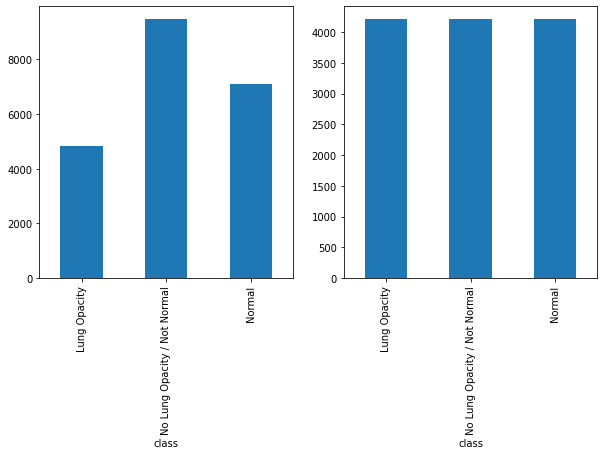

In [ ]:
import matplotlib.pyplot as plt
TRAIN_SAMPLES = 12624 # 4208 x 3 class targets
#Balancing training set
train_df = balance_df(unbalanced_train_df,TRAIN_SAMPLES,target='class')
print(train_df.shape[0], 'Final training size')

- We have run the model with and  without balancing the class variable. We observe that the balanced data gives better results.

In [ ]:
train_df = pd.read_csv('classification_train_df.csv',converters={'class_vector':eval})
valid_df = pd.read_csv('classification_valid_df.csv',converters={'class_vector':eval})
test_df = pd.read_csv('classification_test_df.csv',converters={'class_vector':eval})

In [ ]:
y = train_df.class_vector[0]
type(y)

list

## Build model

In [ ]:
len(np.unique(train_df["path"].to_numpy()))

12624

In [ ]:
train_gen = MyLabelDataGenerator(train_df, augment= True)
valid_gen = MyLabelDataGenerator(valid_df, augment= True)

print(len(train_gen), "# of iterations in one train epoch")
print(len(valid_gen), "# of iterations in one validate epoch")

12624 :No of generator Image
2668 :No of generator Image
394 # of iterations in one train epoch
83 # of iterations in one validate epoch


- When batch size is set at 16,  we will have 789 batches to be completed for training the entire dataset of 12624 records.
- Similarly, we will have 250 batches to be completed for validation purpose.
- MyLabelDataGenerator preprocesses the image and aguments/flips and passes to the model while training.

In [ ]:
Set = 0
imageSet = train_gen[Set][0]
maskSet = train_gen[Set][1]   #Label

In [ ]:
imageSet.shape,maskSet.shape

((32, 299, 299, 3), (32, 3))

In [ ]:
SetIndex = 0
imageIndex = Set*BATCH_SIZE + SetIndex
path = train_gen.filenames[imageIndex]
img = train_gen.getImage(path)

- We are showing a sample image below which is before and after preprocessing. This gives us idea as to how the transformation is done by the preprocess_input package of the selected model before feeding it to the model. 

Text(0.5, 1.0, 'Pre-Processed:Label:[1. 0. 0.]')

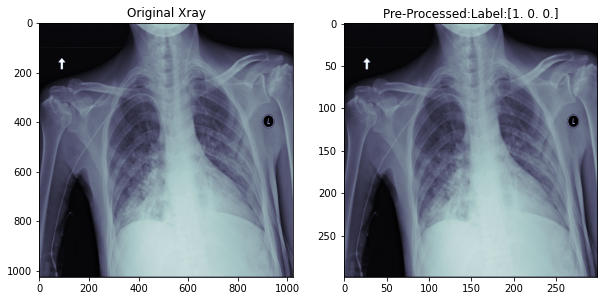

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img, cmap=plt.cm.bone)
ax[0].set_title("Original Xray")
ax[1].imshow(imageSet[SetIndex][:,:,0],cmap=plt.cm.bone)
ax[1].set_title("Pre-Processed:Label:{}".format(maskSet[SetIndex]))
# The images are converted from RGB to BGR, 
#then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

**Background of InceptionV3**

*In this noetbook, we will focus on an efficient deep neural network architecture for computer vision, code named Inception, which derives its name from the famous “we need to go deeper” internet meme.*

- Let us now understand InceptionV3 Nueral Network in brief, which is used for Transfer Learning.
- We can make a bigger model, either in terms of deepness, i.e., number of layers, or the number of neurons in each layer. This can often create complications:
 - Bigger the model, more prone it is to overfitting. This is particularly noticeable when the training data is small.
 - Increasing the number of parameters means we need to increase the existing computational resources.
- The novel solution used in InceptionV3 is to move on to sparsely connected network architectures which will replace fully connected network architectures, especially inside convolutional layers.
- This is achieved by introducing inception layers, a sparsely connected architecture.
- The inception layer is a combination of all 3 layers: 1×1 Convolutional layer, 3×3 Convolutional layer, 5×5 Convolutional layer with their output filter concatenated into a single output vector forming the input of the next stage.
- Additionally, the inceptin layer consists of:
 - 1×1 Convolutional layer before applying another layer, which is mainly used for dimensionality reduction.
 - A parallel Max Pooling layer, which provides another option to the inception layer.
- While creating a subsequent layer in a deep learning model, it should be so built to pay attention to the learnings of the previous layer.
- Suppose, for example, a layer in our deep learning model has learned to focus on individual parts of a face. The next layer of the network would probably focus on the overall face in the image to identify the different objects present there. Now to actually do this, the layer should have the appropriate filter sizes to detect different objects.
- Inception layer allows the internal layers to pick and choose which filter size will be relevant to learn the required information.
- This approach lets us to maintain the “computational budget”, while increasing the depth and width of the network.

In order to use InceptionV3 we need to pre-process the images in a manner suitable for the Deep Neural Network. This is achieved using utility functions created.

**Transfer Learning Background**

-	Most of deep learning models need a whole lot of data (in Millions) and getting vast amounts of labelled data for supervised models can be really difficult, considering the time and effort it takes to label data points.
-	Moreover, getting such a dataset for every domain is tough.
-	Besides, most deep learning models are very specialized to a particular domain or even a specific task. 
-	While these might be state-of-the-art models, with really high accuracy and beating all benchmarks, it would be only on very specific datasets and end up suffering a significant loss in performance when used in a new task which might still be similar to the one it was trained on. 
-	This forms the motivation for transfer learning, which goes beyond specific tasks and domains, and tries to see how to leverage knowledge from pre-trained models and use it to solve new problems.

-	In transfer learning we can leverage knowledge (features, weights etc) from previously trained models for training newer models and even tackle problems like having less data for the newer task.
-	Particularly, in computer vision domain, certain low-level features, such as edges, shapes, corners and intensity, can be shared across tasks, and thus enable knowledge transfer among tasks. 
-	Also, knowledge from an existing task acts as an additional input when learning a new target task.
-	Deep learning systems and models are layered architectures that learn different features at different layers (hierarchical representations of layered features). These layers are then finally connected to a last layer/top layers (usually a fully connected layer/layers, in the case of supervised learning) to get the final output. This layered architecture allows us to utilize a pre-trained network without its final layer/top layers as a fixed feature extractor for other tasks.
-	Idea is to use the outputs of one or more layers of network trained on different task as generic feature extractor. Train a new shallow model on these features.
-	That is, to just leverage the pre-trained model’s weighted layers to extract features but not to update the weights of the model’s layers during training with new data for the new task.
-	Initial lower layers of the network learn very generic features and the higher layers learn very task-specific features.
-	Generally, replace the final layer/top layers (for classification/regression) and train these new shallow layers with limited data available. 
-	Thus, the transfer learning reduces the time & resources required to train and also reduces the large sample requirement. 
-	Transfer Learning makes:
 - Learning process faster
 - More accurate and
 -Training on small data viable

**InceptionV3 Model Implementation using Transfer Learning**

-	We are now interested in classification of classes(No Lung Opacity/Not Normal, Normal and Lung Opacity) using InceptioinV3 model from CXR images. 
- In the process we are faced with two broad issues while training a model.

**Insufficient samples to train a DNN**: 

- We are provided with around 30,000 images which is insufficient to train a Deep Neural Network. Further, we do not have the required resources even to train the model on these many images. Hence, we are constrained to take smaller sample out of these 30,000 for training purposes. This is to overcome high training time due to non-availability of large computing resources. 

**Differences in Natural Images and Medical Images(Different data content)**: 
- The pre-trained networks are mainly trained on natural images. Due to the huge difference between natural images and medical images we have to fine-tune the network to extract task-specific features. 
-	One such fine tuning process is to create a few appropriate layers in lieu of the top layer/layers of the InceptionV3 to train on available data to extract task-specific features. 
-	In transfer learning instead of training all the layers of the model we lock some of the layers and use those trained weights in the locked layers to extract generic features from our data. We choose to retrain some of the modified shallow top layers as those top layers will be specialised to extract task-specific features from the available data. 
-	To achieve this, we have constructed the following new model.
 - **Base Model**: All layers of pretrained InceptionV3 upto "mixed10". That is excluding dense prediction top layer. The pre-trained weights of InceptionV3 will be downloaded only for base model and no weights will be downloaded for last dense layer.
 - **Top Layer**: Top layer consists of following custom built trainable layers in lieu of the existing top layer of InceptioinV3. 
 - - BatchNormalization 1
 - - GlobalAverage Polling 2D
 - - Dropout 1
 - - Dense  with linear activation
 - - BatchNormalization 2
 - - LeakyReLU
 - - Output Dense Layer with softmax activation.
- Since we are now interested in classifying the three classes (No Lung Opacity/Not Normal, Normal and Lung Opacity) the last dense layer of the model should be a 3 unit softmax dense layer.

**Fine Tuning certain base layers of Pre-trained Model apart from Top layers**

-	This is a more involved technique, where we do not just replace the final top layer/layers, but we also selectively retrain some of the previous layers. 
-	Deep neural networks are highly configurable architectures with various hyperparameters. 
-	The initial layers capture generic features, while the later ones focus more on the specific task at hand. By fine tuning these later layers we can capture relevant features of the data on hand and improve performance. 
-	As this is highly involved technique it is parked for taking up in due course.



In [ ]:
def build_pretrained_model():
  #Build base model
  input_shape = MODEL_MAP[BASE_MODEL]['input_shape']
  base_pretrained_model = BaseModel(input_shape =  input_shape, 
                              include_top = False, weights = 'imagenet')
  base_pretrained_model.trainable = False
  #Build Top layer
  lastlayer = MODEL_MAP[BASE_MODEL]['last_conv_layer']
  lastlayershape = base_pretrained_model.get_layer(lastlayer).output_shape[1:]
  pt_features = Input(lastlayershape, name = 'feature_input')
    
  bn_features = BatchNormalization()(pt_features)
  gap = GlobalAveragePooling2D()(bn_features)

  gap_dr = Dropout(DROPOUT)(gap)
  dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
  dr_steps = BatchNormalization()(dr_steps)
  dr_steps = layers.LeakyReLU(0.1)(dr_steps)
  out_layer = Dense(3, activation = 'softmax')(dr_steps)

  attn_model = Model(inputs = [pt_features], 
                    outputs = [out_layer], name = 'top_model')
  #Combine base & top model
  pneu_model = Sequential(name = 'combined_model')
  # base_pretrained_model.trainable = False
  pneu_model.add(base_pretrained_model)
  pneu_model.add(attn_model)
  #Add loss & optimizer
  lr = LEARN_RATE
  decay = lr/10 # or in the factor of 10
  adamOptimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)  
  pneu_model.compile(optimizer =adamOptimizer, loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])
  
  return pneu_model,base_pretrained_model,attn_model

In [ ]:
class_model,base_model,top_model = build_pretrained_model()
class_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "combined_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
top_model (Functional)       (None, 3)                 271235    
Total params: 22,074,019
Trainable params: 266,883
Non-trainable params: 21,807,136
_________________________________________________________________


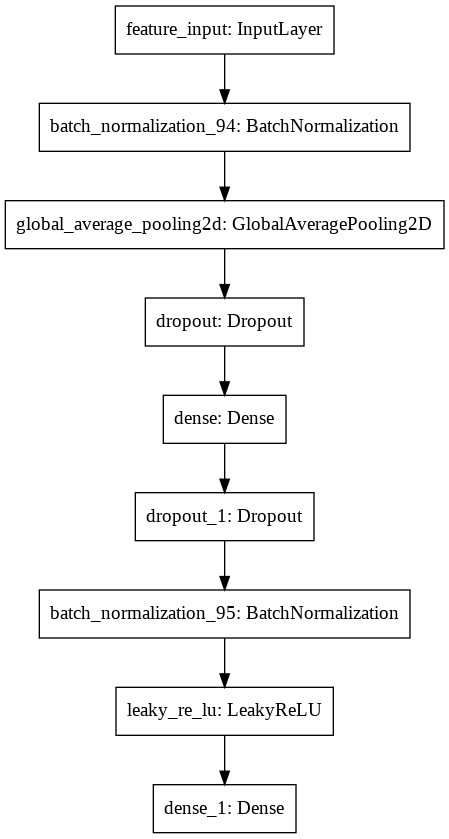

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(top_model)

**Activation function:**<br>
- Every activation function (or non-linearity) takes a single number and performs a certain fixed mathematical operation on it.
- There are several activation functions but let us see the effect of changing four functions:<br>

**Sigmoid:**<br>  
- The sigmoid non-linearity has the mathematical form 
 - σ(x)=1/(1+e−x)
 - It takes a real-valued number and “squashes” it into range between 0 and 1, normalizing the output of each neuron. In particular, large negative numbers become 0 and large positive numbers become 1. Smooth gradient prevents “jumps” in output values. However, the sigmoid non-linearity is rarely used now due to the following factors. 
- Major drawbacks:
 - 1) Sigmoids saturate and kill gradients(Vanishing gradient). If the initial weights are too large then most neurons would become saturated and the network will barely learn. When the neuron’s activation saturates at either tail of 0 or 1, the gradient at these regions is almost zero. It will effectively “kill” the gradient and almost no signal will flow through the neuron to its weights and recursively to its data.
- 2) Sigmoid outputs are not zero-centered. This could introduce undesirable zig-zagging dynamics in the gradient updates for the weights. However, it is noticed that once these gradients are added up across a batch of data the final update for the weights can have variable signs which somewhat mitigates this issue. So batch size is also one of the important factors to be considered while setting up the network.
- Outputs not zero centered and is computationally expensive<br> 

**Tanh:**<br> 
- It is like the Sigmoid function but squashes a real-valued number to the range [-1, 1]. Like the sigmoid neuron, its activations saturate, but unlike the sigmoid neuron its output is zero-centered. Therefore, in practice the tanh non-linearity is always preferred to the sigmoid nonlinearity. 

**ReLU:**<br>
- The Rectified Linear Unit has become very popular in the last few years. It computes the function f(x)=max(0,x). In other words, the activation is simply thresholded at zero.
- It was found to greatly accelerate (e.g. a factor of 6) the convergence of stochastic gradient descent compared to the sigmoid/tanh functions. It is argued that this is due to its linear, non-saturating form.
- Compared to tanh/sigmoid neurons that involve expensive operations (exponentials), the ReLU can be implemented by simply thresholding a matrix of activations at zero. 
- Computationally efficient—allows the network to converge very quickly.
- ReLU is Non Zero centered and is non differentiable at Zero, but differentiable anywhere else.
- The Dying ReLU problem: When inputs approach zero or are negative, the gradient of the function becomes zero, the network cannot perform backpropagation and cannot learn. That is, ReLU units can be fragile during training and can irreversibly die during training since they can knock off the data manifold. With Leaky ReLu this problem can be overcome.


**LeakyReLu**

- The Leaky ReLU (LReLU) modifies the ReLu function to allow small negative values when the input is less than zero.
- That is, Leaky ReLU has a small slope for negative values, instead of altogether zero. 
- For example, leaky ReLU may have y = 0.01x when x < 0.

- The Dying ReLU problem explained above under ReLU can be corrected by making use of Leaky ReLU where slope is changed left of x=0 and thus causing a leak and extending the range of ReLU. We have used Leaky ReLU in the current implementation.
- The other advantage is it speeds up training. There is evidence that having the “mean activation” be close to 0 makes training faster.  
- Unlike ReLU, leaky ReLU is more “balanced,” and may therefore learn faster.

**Softmax**

- A Softmax function is a type of squashing function. Squashing functions limit the output of the function into the range 0 to 1. This allows the output to be interpreted directly as a probability. Similarly, softmax functions are multi-class sigmoids, meaning they are used in determining probability of multiple classes at once. Since the outputs of a softmax function can be interpreted as a probability (i.e.they must sum to 1), a softmax layer is typically the final layer used in neural network functions. It is important to note that a softmax layer must have the same number of nodes as the output layer.
- Softmax turns arbitrary real values into probabilities.
- Softmax classifiers gives probabilities for each class label.
- The Softmax classifier is a generalization of the binary form of Logistic Regression.
- Since the project is with output of multi-class, the softmax is used in the final layer.

**Batch Normalization Background**

- One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is Batch Normalization.
- The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.
- Batch Normalization seeks to overcome this problem by inserting the BatchNorm layer immediately after fully connected layers and before non-linearities. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.
- It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. Hence, the batch normalization layer includes learnable shift and scale parameters for each feature dimension. That is we add extra weights (parameters) that need to be learned by the network.
- Using Batch Normalization in neural networks has become very common. In practice networks that use Batch Normalization are significantly more robust to bad initialization.

**BatchNormalization Analysis**

- Batch normalization may be used on the inputs to the layer before or after the activation function in the previous layer. It may be appropriate before the activation function for activations that may result in non-Gaussian distributions like the rectified linear activation function, the modern default for most network types.
- Our observation from the experimental results : While the test accuracy is similar in both cases the training accuracy has increased when BatchNormalization is before activation layer.
- Hence, we have adopted BatchNormalization layer before activation layer in the current project and tried to bridge the gap between training and test results using other fine tuning methods. 

**GlobalAveragePooling2D**

- Flattening will take a tensor of any shape and transform it into a one dimensional tensor.
- global average pooling (GAP) layers is used to minimize overfitting by reducing the total number of parameters in the model. 
- Similar to max pooling layers, GAP layers are used to reduce the spatial dimensions of a three-dimensional tensor. 
-GlobalAveragePooling2D applies average pooling on the spatial dimensions until each spatial dimension is one, and leaves other dimensions unchanged.
- GAP layers perform a more extreme type of dimensionality reduction, where a tensor with dimensions h×w×d is reduced in size to have dimensions 1×1×d. 
- GAP layers reduce each h×w feature map to a single number by simply taking the average of all hw values.


**Dropout Background**

- Dropout is a technique for improving neural networks by reducing overfitting. Standard backpropagation learning builds up brittle co-adaptations that work for the training data but do not generalize to unseen data. Random dropout breaks up these co-adaptations. This technique was found to improve the performance of neural nets in a wide variety of application domains.
•	Dropout is meant to block information from certain neurons completely to make sure the neurons do not co-adapt.
•	Dropout is typically used to reduce overfitting, in a batch-normalized network. That is, we can be either remove or reduce the strength of overfitting.
•	Typically, dropout is applied after the non-linear activation function. However, when using rectified linear units (ReLU), dropout is applied before the non-linear activation for reasons of computational efficiency and better results of generalization. 
 In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob.
- This indicates that 0 refers to no dropout and 1 means no outputs from the layer. Hence the parameter to be passed should be < 0.50. 
- A good value for dropout in a hidden layer is between 0.5 and 0.2.

**Dropout Analysis**

- From number of trials with different combinations of before and after activation with different dropout rates, the following has emerged:
- The sequence BatchNormalization, Dropout and then activation has given better result than BatchNormalization, activation and then Dropout.
- The Dropout(0, 0.25, 0.5) is tried and Dropout of 0.25 has given best Training and Test accuracy.
- Only with BatchNormalisation without Dropout had fetched Training and Test accuracy with wide gap indicating overfitting, which is now generalized by Dropout layer.



**Stochastic Gradient Descent:**<br>
- A very popular technique that is used along with SGD is called Momentum. Instead of using only the gradient of the current step to guide the search, momentum also accumulates the gradient of the past steps to determine the direction to go. 
- The gradient that is retained from previous iterations is multiplied by a value called "Coefficient of Momentum" which is the percentage of the gradient retained every iteration.
- The previous gradients are also included in subsequent updates, but the weightage of the most recent previous gradients is more than the less recent ones. That is, by taking an exponential average of the gradient steps(the most recent term is weighted as p, the next one as squared of p, then cube of p, and so on).
- Most of the gradient updates are in a zig-zag direction. Momentum helps to move more quickly towards the minima by zeroing out the components in one direction. This technique dampens oscillations in our search.
- In practice, the coefficient of momentum is initialized at 0.5, and gradually annealed to 0.9 over multiple epochs. 
- Hence, we set the momentum for the current project at 0.9 and experimented.<br>

**RMSprop/Root Mean Square Propogation**

- The RMSprop optimizer is similar to the gradient descent algorithm with momentum.
- RMSProp also tries to dampen the oscillations, but in a different way than momentum.
- The RMSprop optimizer restricts the oscillations in the vertical direction.
- Therefore, we can increase our learning rate and our algorithm could take larger steps in the horizontal direction converging faster.
- Exponentially weigh the more recent gradient updates more than the less recent ones just like in momentum.The hyperparameter p is generally chosen to be 0.9, but we may have to tune it.
- The epsilon is to ensure that we do not end up dividing by zero, and is generally chosen to be 1e-10.
- It's also to be noted that RMSProp implicitly performs simulated annealing. Suppose if we are heading towards the minima, and we want to slow down so as to not to overshoot the minima. RMSProp automatically will decrease the size of the gradient steps towards minima when the steps are too large (Large steps make us prone to overshooting)

**Adam**

- RMSProp and Momentum take contrasting approaches. While momentum accelerates search in direction of minima, RMSProp impedes search in direction of oscillations.
- Adam optimizer can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum.
- It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.
- Adam is an adaptive learning rate optimization algorithm that is designed specifically for training deep neural networks.
- To estimate the moments, Adam utilizes exponentially moving averages, computed on the gradient evaluated on a current mini-batch.
- Empirical results have shown that all these algorithms can converge to different optimal local minima given the same loss. However, the adaptive method tends to converge quickly towards minima.  

**Selection of Optimizer**
- We experimented with all the three and found that Adam optimizer generalizes better.
- betas (beta1 and beta2) are hyper-parameters of the Adam algorithm. The default values are 0.9 and 0.999 respectively.
- Accordingly, model is compiled with Adam optimizer, using categorical Crossentropy loss function and categorical accuracy as metrics with default values of betas. The learning rate is set at 1e-4 with decay factor of 0.10. 



In [ ]:
checkpoint = ModelCheckpoint(WEIGHTS_FILE, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                   patience=3, verbose=1, mode='auto', 
                                   min_delta=0.0001, cooldown=5, min_lr=1e-8)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

**Callbacks**

**ModelCheckpoint:**

- ModelCheckpoint is used in conjunction with training, using model.fit() to save a weights and/or model (in a checkpoint file) at some interval, so the weights and/or model can be loaded later to continue the training from the state saved.
- A few options this callback provides include:
 - Whether only weights(save_weights_only = True) are saved, or the whole model is saved.
 - Whether to only keep the weights(save_weights_only = True)and/or model of the model that has achieved the "best performance" so far(save_best_only=True) or whether to save the weights and/or model at the end of every epoch regardless of performance. 
- Since, save_best_only=True, is set the latest best model according to the loss monitored will be overwritten by each new better model weights as filepath does not contain formatting options like {epoch}.
 - Definition of 'best'; which quantity to monitor(monitor='val_loss') and whether it should be maximized or minimized(mode='min').
 - The frequency it should save at. Currently, the callback supports saving at the end of every epoch, or after a fixed number of training batches(used default).

**Early Stopping**

•	The goal of a training is to minimize the loss( mode="min") whether the val loss is no longer decreasing, considering the min_delta (defualt) and patience applied(patience=3). Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.
- The goal of a training is to minimize the loss( mode="min")and the metric to be monitored would be 'val loss'. A model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta(default) and patience applied(patience=3). Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.
- Early stopping is set at patience level of 3, so that, if the validation loss does not improve for 3 continues epochs training terminates.

**Reduce Learning Rate**

- This callback monitors val loss(monitor='val_loss') and if no improvement is seen for a 'patience' numberof epochs(patience=3), the learning rate is reduced.                                  
- Model benefits from reducing the learning rate by a factor(factor=0.2)(new_lr = lr * factor) once learning stagnates. 
- mode can be set as one of {'auto', 'min', 'max'}. 
 - In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing; 
 - In 'max' mode it will be reduced when the quantity monitored has stopped increasing; 
 - In 'auto' mode, the direction is automatically inferred from the name of the monitored quantity.
- verbose when set to 0: quiet mode for messages and on setting to 1 we get update messages.
- cooldown:	number of epochs(cooldown=5) to wait before resuming normal operation after lr has been reduced.
- min_delta:	threshold (epsilon=0.0001) for measuring the new optimum, to only focus on significant changes.
- However, learning rate will not be reduced below lower bound(min_lr=0.0001).
- We have tried to fine tune these hyper-parametes and arrived at the set of parameters showcased. However, there could be a lot of scope to tune these hyper-parameters and further improve the model performance.

- To facilitate resuming training from the last epoch using the weights saved during earlier run model.load_weights is added.
- On reloading the best weights saved and rerunning we were able to get improved performance as under:
- *loss:*   
- *Accuracy:* 
- *val loss*
- *val Accuracy*


##Model Fit

In [ ]:
history = pd.DataFrame()
FORCE_TRAINING = False
if (os.path.isfile(WEIGHTS_FILE) & (FORCE_TRAINING == False) ):
  class_model.load_weights(WEIGHTS_FILE)
  history = loadHistory(HISTORY_FILE)
else:
  if (os.path.isfile(WEIGHTS_FILE)):
    class_model.load_weights(WEIGHTS_FILE)
  history = class_model.fit(train_gen,   # (X_train, y_train)
                        epochs=EPOCHS,
                        validation_data=valid_gen,#(X_valid, y_valid)
                        callbacks=callbacks_list,
                        shuffle=True,
                        verbose=1)
  
  history = saveHistory(history,HISTORY_FILE)

Epoch 1/12
394/394 [==============================] - ETA: 0s - loss: 0.8347 - categorical_accuracy: 0.6155 
Epoch 00001: val_loss improved from inf to 0.75070, saving model to Option-1.InceptionV3/weights.best.final1.h5
394/394 [==============================] - 5155s 13s/step - loss: 0.8347 - categorical_accuracy: 0.6155 - val_loss: 0.7507 - val_categorical_accuracy: 0.6502
Epoch 2/12
394/394 [==============================] - ETA: 0s - loss: 0.7384 - categorical_accuracy: 0.6589
Epoch 00002: val_loss did not improve from 0.75070
394/394 [==============================] - 305s 774ms/step - loss: 0.7384 - categorical_accuracy: 0.6589 - val_loss: 0.7650 - val_categorical_accuracy: 0.6314
Epoch 3/12
394/394 [==============================] - ETA: 0s - loss: 0.7127 - categorical_accuracy: 0.6720
Epoch 00003: val_loss did not improve from 0.75070
394/394 [==============================] - 302s 767ms/step - loss: 0.7127 - categorical_accuracy: 0.6720 - val_loss: 0.7618 - val_categorical_ac

## History

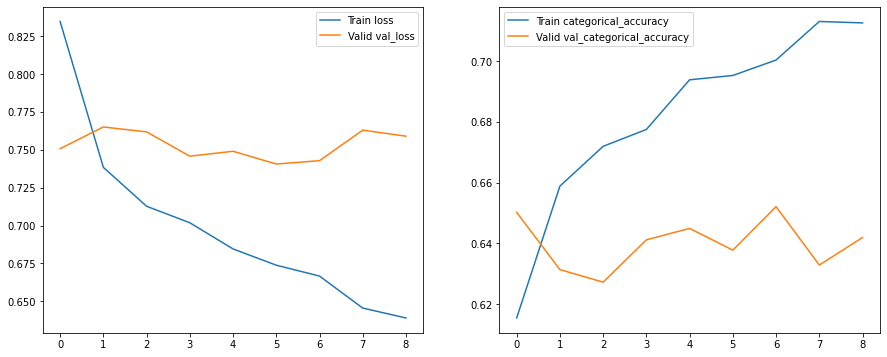

In [ ]:
plot_his(history,'categorical_accuracy')
#Save the model as well for future use

- It is clear from the above graph that as we train for more epochs the Trainining accuracy improves. However, the gap between training and validation scores divergence increases indicating overfitting. 

## Classification-Stage1 performance

In [ ]:
# FORCE_TRAINING = False
patients= []
pred_Y= []
valid_Y = []
if (os.path.isfile(PREDICTION_FILE) & (FORCE_TRAINING == False) ):
  file = open(PREDICTION_FILE, 'rb')
  patients = pickle.load(file)
  pred_Y = pickle.load(file)
  valid_Y = pickle.load(file)
  file.close()
else:
  predict_gen = MyLabelTestDataGenerator(train_df)
  patients, pred_Y,valid_Y = class_predict(predict_gen,class_model,no_of_batch=0)
  file = open(PREDICTION_FILE,'wb')
  pickle.dump(patients, file)
  pickle.dump(pred_Y, file)
  pickle.dump(valid_Y, file)
  file.close()


  0%|          | 0/395 [00:00<?, ?it/s]

12624 :No of generator Image


100%|██████████| 395/395 [05:19<00:00,  1.24it/s]


In [ ]:
predict_gen = MyLabelTestDataGenerator(test_df)
test_patients, test_pred_Y, test_Y = class_predict(predict_gen,class_model,no_of_batch=0)

  0%|          | 0/84 [00:00<?, ?it/s]

2669 :No of generator Image


100%|██████████| 84/84 [14:25<00:00, 10.30s/it]


[[3273  708  227]
 [ 947 2520  741]
 [  66  379 3763]]
                              precision    recall  f1-score   support

                Lung Opacity       0.76      0.78      0.77      4208
No Lung Opacity / Not Normal       0.70      0.60      0.64      4208
                      Normal       0.80      0.89      0.84      4208

                    accuracy                           0.76     12624
                   macro avg       0.75      0.76      0.75     12624
                weighted avg       0.75      0.76      0.75     12624



Text(0, 0.5, 'True')

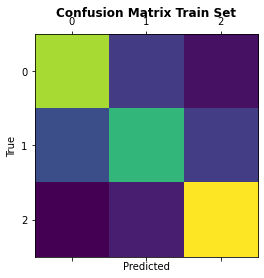

In [ ]:
from sklearn.metrics import confusion_matrix
plt.matshow(confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1)))
print(confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1)))
print(classification_report(np.argmax(valid_Y, -1), 
                            np.argmax(pred_Y,-1), target_names = class_enc.classes_))
plt.title('Confusion Matrix Train Set', fontsize = 12, fontweight="bold")
plt.xlabel('Predicted')
plt.ylabel('True')



[[400 152  50]
 [359 537 286]
 [ 20 127 738]]
                              precision    recall  f1-score   support

                Lung Opacity       0.51      0.66      0.58       602
No Lung Opacity / Not Normal       0.66      0.45      0.54      1182
                      Normal       0.69      0.83      0.75       885

                    accuracy                           0.63      2669
                   macro avg       0.62      0.65      0.62      2669
                weighted avg       0.64      0.63      0.62      2669



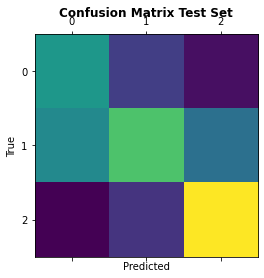

In [ ]:
from sklearn.metrics import confusion_matrix
plt.matshow(confusion_matrix(np.argmax(test_Y, -1), np.argmax(test_pred_Y,-1)))
print(confusion_matrix(np.argmax(test_Y, -1), np.argmax(test_pred_Y,-1)))
print(classification_report(np.argmax(test_Y, -1), np.argmax(test_pred_Y,-1), target_names = class_enc.classes_))
plt.title('Confusion Matrix Test Set', fontsize = 12, fontweight="bold")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

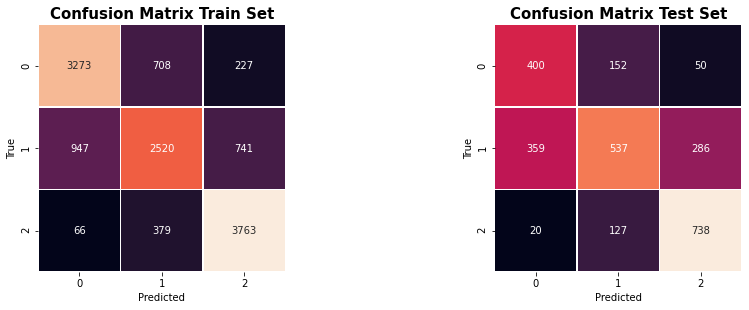

In [ ]:
import seaborn as sns
plt.figure(figsize= (15,10))
plt.subplot(2,2,1)

mat = metrics.confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1))
sns.heatmap(mat, square=True, annot = True, fmt = 'd', cbar = False, linewidth=0.5)
plt.title('Confusion Matrix Train Set', fontsize = 15, fontweight="bold")
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2,2,2)
mat = metrics.confusion_matrix(np.argmax(test_Y, -1), np.argmax(test_pred_Y,-1))
sns.heatmap(mat, square=True, annot = True, fmt = 'd', cbar = False, linewidth=0.5)
plt.title('Confusion Matrix Test Set', fontsize = 15, fontweight="bold")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

- Three Class Confustion Matrix presented here is 3X3 matrix with:
- 0 indicates cases of Pneumonia
- 1 indicates cases of Not Normal/No Pneumonia
- 2 indicates cases of Normal
- True class indexed by coloumn.
- Predicted Class indexed by row.
- Correct predictions by the classifier, where True class matches with predicted class are all on the diagonal.
- Misclassified are off the diagonal.
- For the True class Pneumonia(0), model(predicted) has misclassified as 1 and this happened 940 times.
- For the True class Normal(2), model (predicted) has misclassified as Pneumonia(0) and this happened 90 times.
- These type of large misclassification gives signal to us to verify these images in the provided DICOM files and if required to take up corrective steps in the pre-processing stage(like removal of black borders, ViewPosition alteration, Cropping...).
- If we take the total of row1+row2+row3 for a column 0, we get True Positive + False Positive(Total Predicted label counts in the train/test set for the particular class represented by the column(0)).
- For example for **Training Set**: 
 - Predicted label counts for Pneumonia(0) cases is 4115 which comprises of TP3050+FP(975+90)
 - True(Actual) label counts for Pneumonia(0) cases is 4208 which comprises of TP3050+FN(940+218)
 - Precsion for Pneumonia cases(0) = 3050/4115 = 0.74
 - Recall for Pneumonia cases (0)  = 3050/4208 = 0.72

- On similar lines: 
 - Predicted label counts for Not Normal/No Pneumonia(1) cases is 3989 which comprises of TP510+FP(940+539)
 - True(Actual) label counts for Not Normal/No Pneumonia(1) cases is 4208 which comprises of TP2510+FN(975+723)
 - Precsion for Not Normal/No Pneumonia(1) = 2510/3989 = 0.63
 - Recall for Not Normal/No Pneumonia(1)   = 2510/4208 = 0.60

- Overall Accuracy of Training Set:
 - Sum of elements of diagonal (3050+2510+3579)= 9139
 - Sum of elements of the confusion matrix = Number of training samples used = 12624.
 - Overall Accuracy = 9139/12624 = 0.72

- Weighted average f1 score, which is the combination of both precision and recall is also very low at 0.64.
- Recall & f1 scores being very low the model requires to be tuned.

### ROC AUC

In [ ]:
type(valid_Y[0])

numpy.ndarray

In [ ]:
np.argmax(valid_Y,-1)==0

array([ True,  True, False, ..., False,  True, False])

In [ ]:
# from sklearn.metrics import roc_curve, roc_auc_score
# fpr, tpr, _ = roc_curve(np.argmax(valid_Y,-1)==0, pred_Y)
# fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
# ax1.plot(fpr, tpr, 'b.-', label = 'DenseNet1 (AUC:%2.2f)' % roc_auc_score(np.argmax(valid_Y,-1)==0, pred_Y))
# ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
# ax1.legend(loc = 4)
# ax1.set_xlabel('False Positive Rate')
# ax1.set_ylabel('True Positive Rate');
# ax1.set_title('Lung Opacity ROC Curve')

## Generate class prediction

In [ ]:
pred_df = get_prediction_map(patients,pred_Y)

In [ ]:
pred_df.reset_index(inplace=True)
# pred_df.columns = ['patientId', 'PNEUMONIA', 'NOT_NORMAL', 'NORMAL']

pred_df.rename(columns={'index':'patientId'},inplace=True)
pred_df.head()

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL
0,cc1cefc7-0cb1-4ff1-af66-2bd8e8dd5d57,0.903187,0.095160,0.001653
1,908a9eb7-dc6d-4113-ba9a-28a50140563f,0.803540,0.195681,0.000779
2,3e94f21d-0159-4f9a-8981-3048c0be9f91,0.015495,0.089923,0.894582
3,15d9403c-bf5b-41be-add6-a5c2a9e16d35,0.797698,0.197211,0.005091
4,878ae8b8-f206-4d82-8099-3a56f89bb9c4,0.597438,0.398190,0.004372


- The class(No Lung Opacity/Not Normal, Normal and Lung Opacity) prediction probability for all trained patientIds is created for passing as one of the inputs for training FFNN model in stage 2 for target classification(Pneumonia/Not Pneumonia).

In [ ]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12624 entries, 0 to 12623
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patientId   12624 non-null  object 
 1   PNEUMONIA   12624 non-null  float64
 2   NOT_NORMAL  12624 non-null  float64
 3   NORMAL      12624 non-null  float64
dtypes: float64(3), object(1)
memory usage: 394.6+ KB


In [ ]:
#Dump the prediction as it is very time consuming task.
pred_dump_file = MODEL_NAME + '/class_prediction.csv'
# import pandas as pd
# pred_df = pd.DataFrame()
# if (os.path.isfile(pred_dump_file)):
#   pred_df = pd.read_csv(pred_dump_file)
# else:
pred_df.to_csv(pred_dump_file,index=False)

In [ ]:
pred_df.head()

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL
0,cc1cefc7-0cb1-4ff1-af66-2bd8e8dd5d57,0.903187,0.095160,0.001653
1,908a9eb7-dc6d-4113-ba9a-28a50140563f,0.803540,0.195681,0.000779
2,3e94f21d-0159-4f9a-8981-3048c0be9f91,0.015495,0.089923,0.894582
3,15d9403c-bf5b-41be-add6-a5c2a9e16d35,0.797698,0.197211,0.005091
4,878ae8b8-f206-4d82-8099-3a56f89bb9c4,0.597438,0.398190,0.004372


In [ ]:
# pred_df.drop(pred_df.columns[0],inplace=True,axis=1)

In [ ]:
merged_pred_meta_df = get_pred_merged_meta_data(pred_df,full_df)
merged_pred_meta_df.head()

,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
cc1cefc7-0cb1-4ff1-af66-2bd8e8dd5d57,0.903187,0.095160,0.001653,23.0,1.0,1.0,1.0
908a9eb7-dc6d-4113-ba9a-28a50140563f,0.803540,0.195681,0.000779,25.0,1.0,1.0,1.0
3e94f21d-0159-4f9a-8981-3048c0be9f91,0.015495,0.089923,0.894582,38.0,0.0,0.0,0.0
15d9403c-bf5b-41be-add6-a5c2a9e16d35,0.797698,0.197211,0.005091,55.0,1.0,1.0,1.0
878ae8b8-f206-4d82-8099-3a56f89bb9c4,0.597438,0.398190,0.004372,35.0,1.0,1.0,1.0


- The class probability predicted for training data is merged with metadata(Age, Sex, ViewPosition) and a consolidated dataframe is created for passing as inputs for training FFNN model in stage 2 for target classification(Pneumonia/Not Pneumonia).
- In the dataframe so created the patient index is transformed into a separate column. 

In [ ]:
merged_pred_meta_df.reset_index(inplace=True)
merged_pred_meta_df.rename(columns={'index':'patientId'},inplace=True)
merged_pred_meta_df.head()

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
0,cc1cefc7-0cb1-4ff1-af66-2bd8e8dd5d57,0.903187,0.095160,0.001653,23.0,1.0,1.0,1.0
1,908a9eb7-dc6d-4113-ba9a-28a50140563f,0.803540,0.195681,0.000779,25.0,1.0,1.0,1.0
2,3e94f21d-0159-4f9a-8981-3048c0be9f91,0.015495,0.089923,0.894582,38.0,0.0,0.0,0.0
3,15d9403c-bf5b-41be-add6-a5c2a9e16d35,0.797698,0.197211,0.005091,55.0,1.0,1.0,1.0
4,878ae8b8-f206-4d82-8099-3a56f89bb9c4,0.597438,0.398190,0.004372,35.0,1.0,1.0,1.0


In [ ]:
merged_pred_meta_df[merged_pred_meta_df.Target==1].sample(5)

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
1965,72dc0bc2-8c6a-4214-b06f-862e9e8444bd,0.577369,0.343510,0.079121,64.0,1.0,1.0,1.0
10493,be6444fb-5c41-436a-ad7b-278dc59eec67,0.776164,0.223667,0.000169,65.0,0.0,1.0,1.0
1624,cae03a83-a903-4087-b324-a67fe98638d4,0.968049,0.031901,0.000049,41.0,1.0,0.0,1.0
1369,bda78d8f-77ca-4806-a095-e0df852f821f,0.712120,0.286782,0.001098,69.0,0.0,1.0,1.0
12381,a95a4817-482e-48bd-96bf-c661573e7032,0.317394,0.497894,0.184712,17.0,1.0,1.0,1.0


- This provides us view of sample distribution of the dataframe.
- There are cases where the probability of Not Normal and Pneumonia case are very close to each other. In order to provide more features to correctly identify the pneumonia cases we have explicitly used few elements of metadata as features which is found to be having predictive power.
These may be the special cases where the Radiologist is not able to identify from CXR whether the Opacity is attributable to pneumonia or not. 
This is where the application will be most helpful in correctly diagnosing pneumonia cases.

- Based on the probability of class predcition output of stage 1 we can classify the training dataset into No Lung Opacity/Not Normal, Normal and Lung Opacity. 
- Based on this classification and mappings of target we can find the predicted target for the training set. 
- We here below provide visualization of the distribution of predicted(at stage 1) target variable of training set. 
- The target variable is significantly imbalanced and requires balancing for better results.



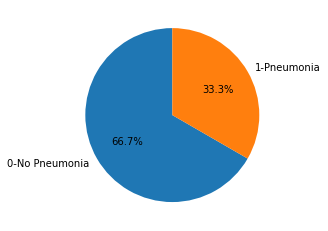

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
unique_values, count = np.unique(merged_pred_meta_df['Target'], return_counts=True)

plt.pie(count, labels = ['0-No Pneumonia', '1-Pneumonia'],
          autopct='%1.1f%%', startangle=90)
plt.show()
#Need to balance the data here.

In [ ]:
#Split the data into train & valid
y = merged_pred_meta_df['Target'].to_numpy()
X = merged_pred_meta_df[merged_pred_meta_df.columns[1:7]]

- We separate features X and target y for splitting.


In [ ]:
X.head()

,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition
0,0.903187,0.095160,0.001653,23.0,1.0,1.0
1,0.803540,0.195681,0.000779,25.0,1.0,1.0
2,0.015495,0.089923,0.894582,38.0,0.0,0.0
3,0.797698,0.197211,0.005091,55.0,1.0,1.0
4,0.597438,0.398190,0.004372,35.0,1.0,1.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

- We make train/test split of the data to be fed into FFNN model in the ratio of 90% to 10% for target classifiction. 

## FFNN model

In [ ]:
#Build neural netwrok

from tensorflow.keras.layers import  Reshape
def add_layer(model):
  kinit ='he_normal' #tf.keras.initializers.he_normal()
  actv = 'relu' #activation.relu
  # model.add(Reshape((6,),input_shape=(32,32,)))
  # #Add batch normalization to avoid NAN in training loss
  # model.add(kl.normalization.BatchNormalization())
  #Add input layer -- 
  model.add(Dense(6,input_dim= 6,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #How many hidden layer? No clear rule, trial & error? Literature says, it 3 hidden layer sufficient
  #Add hidden layer -1
  model.add(Dense(16,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #Add hidden layer -2
  model.add(Dense(8,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #Add hidden layer -3
  model.add(Dense(4,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())


  #Add output layer -- number of output neoron 1(as the number of output is 10)
  #Add hidden layer -1
  model.add(Dense(1,activation='sigmoid',kernel_initializer=kinit))
  
nn_model = Sequential()
add_layer(nn_model)

In [ ]:
def fit_model(opt,model,epoch=60,verbo=1,batchsize=128):
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
  history = model.fit(X_train, y_train, validation_data=(X_test,y_test),batch_size=batchsize, epochs=epoch, verbose=verbo)
  return history
opt = Adam(lr = LEARN_RATE)
history = fit_model(opt,nn_model)

Epoch 1/60
89/89 [==============================] - 1s 7ms/step - loss: 0.6498 - accuracy: 0.5695 - val_loss: 0.6788 - val_accuracy: 0.6358
Epoch 2/60
89/89 [==============================] - 0s 5ms/step - loss: 0.5460 - accuracy: 0.7930 - val_loss: 0.6568 - val_accuracy: 0.6975
Epoch 3/60
89/89 [==============================] - 0s 5ms/step - loss: 0.4186 - accuracy: 0.8276 - val_loss: 0.6963 - val_accuracy: 0.5384
Epoch 4/60
89/89 [==============================] - 0s 5ms/step - loss: 0.3833 - accuracy: 0.8402 - val_loss: 0.6441 - val_accuracy: 0.6176
Epoch 5/60
89/89 [==============================] - 0s 5ms/step - loss: 0.3714 - accuracy: 0.8409 - val_loss: 0.5671 - val_accuracy: 0.8044
Epoch 6/60
89/89 [==============================] - 0s 5ms/step - loss: 0.3633 - accuracy: 0.8402 - val_loss: 0.7323 - val_accuracy: 0.5653
Epoch 7/60
89/89 [==============================] - 0s 5ms/step - loss: 0.3653 - accuracy: 0.8422 - val_loss: 0.3700 - val_accuracy: 0.8298
Epoch 8/60
89/89 [==

In [ ]:
HISTORY_FILE = MODEL_NAME+"/" +"history_FFNN_final1.csv"
his_ffnn = saveHistory(history,HISTORY_FILE)

## Classification Performance(Recall)

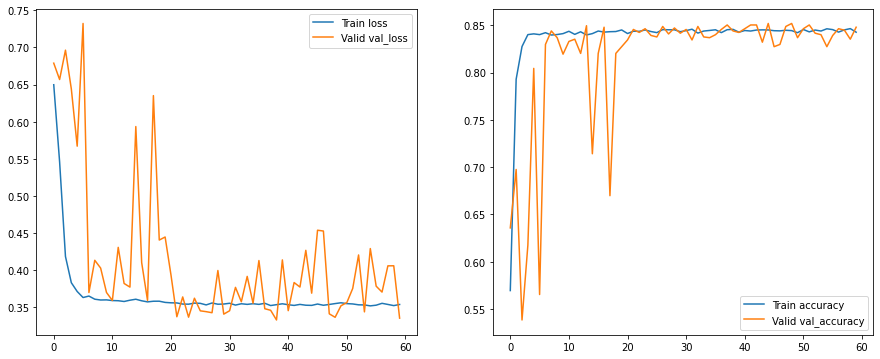

In [ ]:
plot_his(his_ffnn,'accuracy')

In [ ]:
pred_y_train = nn_model.predict(X_train)
pred_y_train_class = (pred_y_train >= 0.45).astype(np.int)

In [ ]:
pred_y = nn_model.predict(X_test)

In [ ]:
pred_y;

In [ ]:
pred_y_class = (pred_y >= 0.45).astype(np.int)

In [ ]:
y_test = (y_test >= 0.5).astype(np.int)


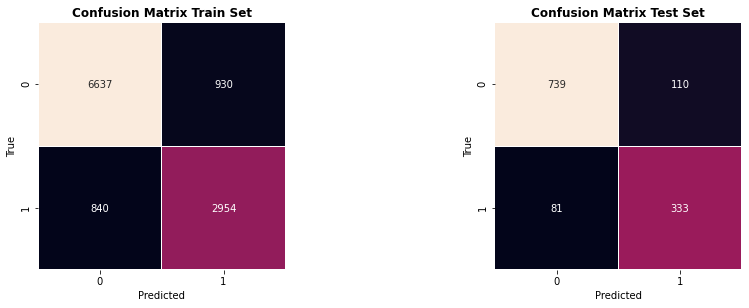

In [ ]:
plt.figure(figsize= (15,10))
plt.subplot(2,2,1)

mat = metrics.confusion_matrix(y_train, pred_y_train_class)
sns.heatmap(mat, square=True, annot = True, fmt = 'd', cbar = False, linewidth=0.5)
plt.title('Confusion Matrix Train Set', fontsize = 12, fontweight="bold")
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.show()

plt.subplot(2,2,2)
mat = metrics.confusion_matrix(y_test, pred_y_class)
sns.heatmap(mat, square=True, annot = True, fmt = 'd', cbar = False, linewidth=0.5)
plt.title('Confusion Matrix Test Set', fontsize = 12, fontweight="bold")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print("Confusion Matrix:- \n", metrics.confusion_matrix(y_train, pred_y_train_class), "\n")
print("Classification Report Test Set:- \n", metrics.classification_report(y_train, pred_y_train_class))

Confusion Matrix:- 
 [[6637  930]
 [ 840 2954]] 

Classification Report Test Set:- 
               precision    recall  f1-score   support

         0.0       0.89      0.88      0.88      7567
         1.0       0.76      0.78      0.77      3794

    accuracy                           0.84     11361
   macro avg       0.82      0.83      0.83     11361
weighted avg       0.85      0.84      0.84     11361



In [ ]:
print("Confusion Matrix:- \n", metrics.confusion_matrix(y_test, pred_y_class), "\n")
print("Classification Report Test Set:- \n", metrics.classification_report(y_test, pred_y_class))

Confusion Matrix:- 
 [[739 110]
 [ 81 333]] 

Classification Report Test Set:- 
               precision    recall  f1-score   support

           0       0.90      0.87      0.89       849
           1       0.75      0.80      0.78       414

    accuracy                           0.85      1263
   macro avg       0.83      0.84      0.83      1263
weighted avg       0.85      0.85      0.85      1263



**Metrics Background**

**Accuracy:**

- Accuracy simply measures how often the classifier makes the correct prediction. It is the ratio between the number of correct predictions and the total number of predictions (the number of test data points). Accuracy = No. of correct predictions/Total No. of predictions.
 - TP/(TP+TN+FP+FN)

**Precision & Recall:**

- Precision and recall are actually two metrics. But they are often used together.
- Precision answers the question: Out of the items that the classifier predicted to be true, how many are actually true?
- Recall answers the question: Out of all the items that are actually true, how many are found to be true by the classifier?

- The precision score quantifies the ability of a classifier to not label a negative example as positive. High precision implies not many 'not pneumonia' cases are wrogly labeled as pneumonia. So wrong treatement is avoided. 
- The precision score can be interpreted as the probability that a positive prediction made by the classifier is positive. That is precision score is probability of pneumonia cases predicted by the classifier is infact pneuonia cases. 
- The score is in the range [0,1] with 0 being the worst, and 1 being perfect.

- Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made(Correct positive predictions out of actual positives).
- Unlike precision that only comments on the correct positive predictions out of all positive predictions, recall provides an indication of missed positive predictions.
- In this way, recall provides some notion of the coverage of the positive class.
- High recall score could be interpreted as high probability of identifying positive cases. That is the probability of classifier identifying pneumonia cases out of the positive cases. 
- If the recall is low the risk of not identify pneumonia cases will be high and the patient will be deprived of treatment. Hence, recall should be high in this case. 
- The precision and recall scores are calculated as under:
 - Precision = No. of True Positive/(No. of True Positive + No. of False Positive). That is , the denominator is Predicted Positives.
 - Recall = No. of True Positive/( No. of True Positive + No. of False Negative. That is the denominator is Actual Positives.

**F1 Score:**

- The F1-score is a single metric that combines both precision and recall via their harmonic mean:
 - F1 Score =2xprecision∗recall/(precision + recall)
- The score lies in the range [0,1] with 1 being ideal and 0 being the worst. 
- Unlike the arithmetic mean, the harmonic mean tends toward the smaller of the two elements. Hence the F1 score will be small if either precision or recall is small.


### ROC curve

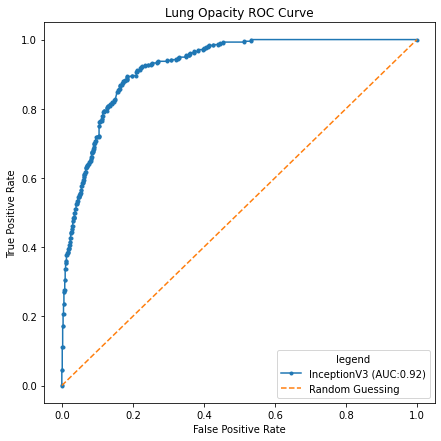

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('xx-small')
fpr, tpr, _ = roc_curve(y_test, pred_y)
fig, ax1 = plt.subplots(1,1, figsize = (7, 7))
ax1.plot(fpr, tpr, marker='.', label = 'InceptionV3 (AUC:%2.2f)' % roc_auc_score(y_test, pred_y))
ax1.plot(fpr, fpr, linestyle='--', label = 'Random Guessing')
ax1.legend(title='legend',  loc='lower right')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Lung Opacity ROC Curve');

- The presence of imbalanced data may distort the algorithms and its predicting performance. This problem often happens in real world dataset, since people with certain behavior account for relatively smaller part. 
- In the current project being handled the Pneumonia/Not Pneumonia is surely a significantly imbalanced dataset.
- How to deal with this problem can be divided into two parts:
 - First, change the way of measuring algorithm’s performance. As a traditional and common measurement of performance, the test accuracy rate cannot be simply used here because the model will tend to fit the majority class better to improve the overall accuracy. However, we prefer to be more successful in identifying people who have pneumonia than the overall power of prediction. Therefore, we will have to use ROC (Receiver Operating Characteristic) curve and AUC (Area Under Curve )as the performance measurement.

 - Second, change the dataset using resampling method or apply different weights to the observations in objective function. 
  - The most commonly used resampling method is oversampling (sample with replacement from the group with less data until the number equals to the larger group).
  - Undersampling (sample with replacement from the group with more data until the number equals to the lesser group) and 
  - mix sampling (mixture of oversampling and undersampling). The method with reweighting can vary a lot by applying different weights.

**Background of ROC Curve**

- It is one of the most important evaluation metrics for checking any classification model’s performance. 
- It is also written as AUROC (Area Under the Receiver Operating Characteristics)
- AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. 
- ROC is a probability curve and AUC represents degree or measure of separability. 
- It tells how much model is capable of distinguishing between classes. - Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. 
- By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.
- The ROC curve is plotted with TPR(True Positive Rate) against the FPR(False Positive Rate) where TPR is on y-axis and FPR is on the x-axis.
 - TPR//Recall//Sensitivity = TP/(TP+FN)
 - Specificity = TN/(TN+FP)
 - FPR = 1-Specificity = FP/(TN+FP)
- An excellent model has AUC near to the 1 which means it has good measure of separability. 
- A poor model has AUC near to the 0 which means it has worst measure of separability. In fact it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. 
- And when AUC is 0.5, it means model has no class separation capacity whatsoever.
- When AUC is 0.9, it means there is 90% chance that model will be able to distinguish between positive class and negative class.

- Among all the models experimented, InceptionV3 has given consistent and good performance. 
- Hence, Option 1 comprises of classification Module based on InceptionV3 model in stage 1 for classification of classes followed by FFNN model for classifiction of Target variable in stage 2 and then RetinaNet for detection. 

- **This classification module comprising of the sequential InceptionV3 and FFNN models itself can be used as a standalone Global Pneumonia Classification System for taking up clinical decisions.** 

- Going further for detection of opacity we have two choices:
 - **Choice 1**: Use only the images of pneumonia cases identified by the final classifiction model(FFNN) to be passed to the RetinaNet model for detection. That is the corresponding images classified as pneumonia cases by the classification Module only will be filtered and fed to the detection model based on RetinaNet. 

 - **Choice 2**: Additionally pass the probability of pneumonia arrived at by the stage 2 of classification module weighted(based on GridSearchCV) appropriately with  predicted confidence score arrived by the RetinaNet model. This additional information has influence on the predicted bounding box confidence score. This is only the concept but not implemented. But can be implemented easily as all data required is available. 

- We have created a single pipeline where given an image, the system first exectutes two stage classification and identifies whether the image pertains to pneumonia case or not and if it is classified as penumonia case it will automatically proceed to process further for detecting the bounding boxes via RetinaNet model.

- In case the DICOM files are not provided and only JPG files are given as CXR input, then we will not have metadata information to run through the FFNN model of Stage 2 classification. In such cases, the pipline will skip the FFNN stage 2 process and will pass jpg images, of pneumonia cases only as identified at stage 1, to RetinNet model for detection of opacity by predicting bounding boxes.

- In such cases of JPG file input, as per the settings, the probability of pneumonia cases arrived at stage 1 classification is also passed to RetinaNet for imporving the accuracy of the confidence score predicted. 



## Conclusion

> Indented block

